<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Experiments/De_Scrambling_Text_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting Scrambled sequence into a Unscrambled sequence using attention. 

Reference: https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [1]:
!pip install aicrowd-cli
API_KEY = '' 
!aicrowd login --api-key $API_KEY

# Downloading the Dataset
!rm -rf data
!mkdir data
!aicrowd dataset download --challenge de-shuffling-text -j 3 -o data

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 215kB 8.2MB/s 
     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 174kB 8.8MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
API Key valid
Saved API Key successfully!
train.csv:   0% 0.00/7.00M [00:00<?, ?B/s]
train.csv: 10

In [2]:
# Importing all the packages we need 
import tensorflow as tf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Importing the data 

train_data = pd.read_csv('data/train.csv')
val_data = pd.read_csv('data/val.csv')
test_data = pd.read_csv('data/test.csv')

# Printing out all shapes of our data 
print(f'Shape of the train data: {train_data.shape}')
print(f'Shape of the validation data: {val_data.shape}')
print(f'Shape of the test data: {test_data.shape}')


Shape of the train data: (40001, 2)
Shape of the validation data: (4001, 2)
Shape of the test data: (10000, 3)


In [4]:
# How does our train data looks like? 
train_data.head()

,text,label
0,"presented here Furthermore, naive improved. im...","Furthermore, the naive implementation presente..."
1,vector a in a form vector multidimensional spa...,Those coefficients form a vector in a multidim...
2,compatible of The model with recent is model s...,The model is compatible with a recent model of...
3,but relevance outlined. hemodynamics its based...,"The model is based on electrophysiology, but i..."
4,of transitions lever-like involve reorientatio...,Conformational transitions in macromolecular c...


In [5]:
# Shuffling our train data 
train_data_shuffled = train_data.sample(frac = 1 , random_state = 42)
train_data_shuffled.head() , train_data_shuffled.shape

(                                                    text                                              label
 32824  on work, supervised label image the segmentati...  In our work, we focus on the weakly supervised...
 16298  we small of a for set work, In this features i...  In this work, we propose a small set of featur...
 30180  ($G_h^{Der}$ to factors the contributes $\tau_...  The increment of both factors ($G_h^{Der}$ and...
 6689   new precise particular, for entailment. bounds...  In particular, we provide new precise analytic...
 26893  a these causation Incorporating features, defi...  Incorporating these three features, a definiti...,
 (40001, 2))

In [6]:
# Splitting sentences and labels
train_sentences = train_data_shuffled['text'].to_numpy()
train_labels = train_data_shuffled['label'].to_numpy()

val_sentences = val_data['text'].to_numpy()
val_labels = val_data['label'].to_numpy()

test_sentences = test_data['text'].to_numpy()
test_labels = test_data['label'].to_numpy()


# Checking the shapes 
print(f'Shape of the train sentences: {train_sentences.shape}')
print(f'Shape of the validation sentences: {val_sentences.shape}')
print(f'Shape of the train labels: {train_labels.shape}')
print(f'Shape of the validation labels: {val_labels.shape}')

Shape of the train sentences: (40001,)
Shape of the validation sentences: (4001,)
Shape of the train labels: (40001,)
Shape of the validation labels: (4001,)


In [7]:
# Creating a tf.data.dataset of our sentences and labels 

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels)).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels))

# Adding a batch 
train_dataset = train_dataset.batch(64)

train_dataset , val_dataset

(<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.string)>,
 <TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>)

In [8]:
# Looking into our train_dataset just a batch (only 5 first texts in a batch)
for scrambled_text , unscrambled_text in train_dataset.take(1):
  print(f'Below is the Scrambled version:\n {scrambled_text[:5]}')
  print('\n----------\n')
  print(f'Below is the Un-Scrambled version:\n {unscrambled_text[:5]}')

Below is the Scrambled version:
 [b'to impaired loss processing information whether a information of transfer. local leads Therefore, we asked'
 b'with common Our approach issues a within adaptive proposed deals framework. these regularized'
 b'a about consider model We causal system, look for a facts. arguments and physical for'
 b'similar curves. properties The new have curves to $q$-B$\\acute{e}$zier some'
 b'generate cGAN the the sharper feedback from helps The first second cGAN images.']

----------

Below is the Un-Scrambled version:
 [b'Therefore, we asked whether impaired local information processing leads to a loss of information transfer.'
 b'Our proposed adaptive regularized approach deals with these issues within a common framework.'
 b'We consider a causal model for a physical system, and look for arguments about facts.'
 b'The new curves have some properties similar to $q$-B$\\acute{e}$zier curves.'
 b'The feedback from the second cGAN helps the first cGAN generate sharpe

In [9]:
# Creating text vectorization layer for the scrambled words 
max_vocab_length = 10000

input_text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    standardize = 'lower_and_strip_punctuation' , 
    ngrams = 2 , 
    max_tokens = max_vocab_length 
)

# Fitting on our train sentences (scrambled words )
input_text_vectorizer.adapt(train_sentences)

In [10]:
# First 10 words from the vocabulary 
input_text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'of', 'a', 'in', 'to', 'is', 'and', 'we']

In [11]:
# Creating a text vectorization layer for the unscrambled words 
output_text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    standardize = 'lower_and_strip_punctuation' , 
    ngrams = 2, 
    max_tokens = max_vocab_length
)

# Fitting on our train labels (unscrambled words)
output_text_vectorizer.adapt(train_labels)

In [12]:
# First 10 words from the vocab 
output_text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'of', 'a', 'in', 'to', 'is', 'and', 'we']

In [13]:
# Passing a scrambled text (strings) into our layer 
scrambled_tokens = input_text_vectorizer(scrambled_text)
scrambled_tokens[:3]

<tf.Tensor: shape=(3, 29), dtype=int64, numpy=
array([[   6, 6562,  346,  195,   66, 1549,    4,   66,    3,  545,  179,
         685,  201,    9, 6696,    1,    1,    1,    1,    1,    1, 4742,
        3118,    1,    1,    1,    1,    1,    1],
       [  16,  313,   15,   31,  805,    4,  366,  594,   23, 2724,   64,
          26, 3192,    1,    1, 2006,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    0,    0,    0,    0],
       [   4,  317,  199,   28,    9,  968,   73, 3220,   10,    4, 4668,
        2095,    8, 1074,   10,    1,    1,    1, 2119,    1,    1,    1,
           1,  316,    1,    1,    1,    1,    1]])>

In the above example we passed our text (strings) into our text vectorizer layer and it returns us a vector of token ID's of our sequence. 

Likewise we can get the corresponding sequence of a token ID, that is convert token ids back to text using `get_vocabulary()` method. 

In [14]:
# Creating a numpy array of the vocabulary
input_vocab = np.array(input_text_vectorizer.get_vocabulary())
input_vocab


array(['', '[UNK]', 'the', ..., 'paper deep', 'packing', 'package the'],
      dtype='<U26')

In [15]:
# Indexing our scrambled tokens into the array of vocbulary
tokens = input_vocab[scrambled_tokens.numpy()]
print(f'Actual sequence:\n\n {scrambled_text[:3]}\n')
print(f'\nThe sequence in tokens:\n\n {tokens[:3]}') 

Actual sequence:

 [b'to impaired loss processing information whether a information of transfer. local leads Therefore, we asked'
 b'with common Our approach issues a within adaptive proposed deals framework. these regularized'
 b'a about consider model We causal system, look for a facts. arguments and physical for']


The sequence in tokens:

 [['to' 'impaired' 'loss' 'processing' 'information' 'whether' 'a'
  'information' 'of' 'transfer' 'local' 'leads' 'therefore' 'we' 'asked'
  '[UNK]' '[UNK]' '[UNK]' '[UNK]' '[UNK]' '[UNK]' 'a information'
  'information of' '[UNK]' '[UNK]' '[UNK]' '[UNK]' '[UNK]' '[UNK]']
 ['with' 'common' 'our' 'approach' 'issues' 'a' 'within' 'adaptive'
  'proposed' 'deals' 'framework' 'these' 'regularized' '[UNK]' '[UNK]'
  'our approach' '[UNK]' '[UNK]' '[UNK]' '[UNK]' '[UNK]' '[UNK]' '[UNK]'
  '[UNK]' '[UNK]' '' '' '' '']
 ['a' 'about' 'consider' 'model' 'we' 'causal' 'system' 'look' 'for' 'a'
  'facts' 'arguments' 'and' 'physical' 'for' '[UNK]' '[UNK]' '[U

## Modelling Part 

Here we are going to build a seq2seq architecture from scratch we will start building from, 
- Encoder 
- Decoder 
- Attention Head 

Since we are going to use a lot of low level API
s where it's easy to get the shapes wrong, this `SpaceChecker` is used to check shapes throughout the tutorial. 

In [16]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [17]:
# Defining needed constants for our model 
embedding_dim = 256 
units = 1024 

#### Building our encoder layer 
The encoder, 
- Takes a list of token IDs (from input_text_vectorizer)
- Looks up an embedding vector for each token (we will create that using `layers.Embedding`) 
- Processes the embeddings into a new sequences (using a `layers.GRU`)
- **Returns**
  - The processed sequence. This will be passed to the attention head.
  - The internal state. This will be used to initialize the encoder. 


In [18]:
# Building a Encoder layer 

class Encoder(tf.keras.layers.Layer): 
  def __init__(self ,input_vocab_size , embedding_dim , enc_units):
    super(Encoder , self).__init__()
    self.enc_units = enc_units 
    self.input_vocab_size = input_vocab_size 

    # This embedding layer converst tokens to vectors 
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size , 
                                             embedding_dim)
  
    # Using GRU layers to processes those vectors sequentially 
    self.gru = tf.keras.layers.GRU(self.enc_units , 
                                 return_sequences = True , 
                                 return_state = True , 
                                 recurrent_initializer = 'glorot_uniform')
  
  def call(self , tokens , state = None):
    shape_checker = ShapeChecker() 
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layers looks up the embedding for each token
    vectors = self.embedding(tokens) # gives us the vectors for each token
    shape_checker(vectors , ('batch' , 's' , 'embed_dim'))

    # 3. The GRU processes the embedding sequence 
    #       output shape: (batch , s , enc_units)
    #       state_shape: (batch , enc_units)
    output , state = self.gru(vectors , initial_state = state)
    shape_checker(output , ('batch' ,'s' , 'enc_units'))
    shape_checker(state , ('batch' , 'enc_units'))

    # 4. Return the new sequence and it's state 
    return output , state
  


Alright that's complicated let's see how it works. 

In [19]:
# Firstly conver the input text to token using Textvectorizer 
example_tokens = input_text_vectorizer(scrambled_text)
example_tokens

<tf.Tensor: shape=(64, 29), dtype=int64, numpy=
array([[   6, 6562,  346, ...,    1,    1,    1],
       [  16,  313,   15, ...,    0,    0,    0],
       [   4,  317,  199, ...,    1,    1,    1],
       ...,
       [   5,  489,   11, ...,    0,    0,    0],
       [  17,    7,   73, ...,    1,    0,    0],
       [ 456,   12,   53, ..., 3593,    0,    0]])>

In [20]:
# Encode the input sequence (apply everything we wrote in our class)
encoder = Encoder(input_vocab_size= input_text_vectorizer.vocabulary_size() , 
                  embedding_dim = embedding_dim, enc_units = units)


In [21]:
# Unravelling with each variable by applying on our example toke

example_encoder_output , example_encoder_state = encoder(example_tokens)

In [22]:
# Good, let's print them one by one 
print(f'Input batch, shape (batch): {scrambled_text.shape}\n')
print(f'Input batch tokens , shape (batch ,s): {example_tokens.shape}\n')

print(f'Encoder output , shape (batch, s , units): {example_encoder_output.shape}\n')
print(f'Encoder state , shape (batch, units): {example_encoder_state.shape}\n')

Input batch, shape (batch): (64,)

Input batch tokens , shape (batch ,s): (64, 29)

Encoder output , shape (batch, s , units): (64, 29, 1024)

Encoder state , shape (batch, units): (64, 1024)



##### **Attention Head** 

- The decoder uses attention to selectively focus on parts of the input sequence. 
- The attention takes a **sequence of vectors** for each example and returns an **`attention vector` for each example**.
- This attention layer is similar to `layers.GlobalAveragePooling1D` but the attention layer performs a weighted average. 

The attention head equation, 
- Calculates the attention weights, as a softmax across the encoders output and sequence. 
- Calculates the context vector as the weighted sum of the encoder outputs. 

We use (Bahdanau's additive attention)[https://arxiv.org/pdf/1409.0473.pdf] and TensorFlow includes the implementations of both as `layers.Attention` and `layers.AdditiveAttention`. 


In [26]:
# Building the Bahdanau's attention head 

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self , units):
    super().__init__()
    # Calculating the Bahadanau attention 
    self.W1 = tf.keras.layers.Dense(units , use_bias = False)
    self.W2 = tf.keras.layers.Dense(units , use_bias = False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self , query , value , mask):
    shape_checker = ShapeChecker() 
    shape_checker(query , ('batch' , 't' , 'query_units'))
    shape_checker(value , ('batch' , 's' , 'value_units') )
    shape_checker(mask , ('batch' , 's'))

    # Calculating W1@ht
    w1_query = self.W1(query)
    shape_checker(w1_query , ('batch' , 't' , 'attn_units'))

    # Calculating W2@ht 
    w2_key = self.W2(value)
    shape_checker(w2_key , ('batch' , 's' , 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1] , dtype = bool)
    value_mask = mask

    # Creating the context vector
    context_vector, attention_weights = self.attention(
        inputs = [w1_query ,value , w2_key] , 
        mask = [query_mask , value_mask], 
        return_attention_scores = True,
    )
    shape_checker(context_vector , ('batch' , 't' , 'value_units'))
    shape_checker(attention_weights , ('batch' , 't' , 's'))

    return context_vector , attention_weights

In [27]:
# Testing the attention layer by creating a bahdanau attention layer 
attention_layer = BahdanauAttention(units)
attention_layer

The above Bahdanau layer will take 3 inputs,

- `query`: this will be generated by decoder later
- `value`: output of the encoder 
- `mask`: to exclude the padding, `example_tokens ! = 0`


The vectorized implementation of the attention layer let's you pass a batch of sequences of query vectors and a batch of sequence of value vectors.

In [33]:
# Later, the decoder will generate this attention query 
example_attention_query = tf.random.normal(shape = [len(example_tokens) , 2 , 10])
example_attention_query

<tf.Tensor: shape=(64, 2, 10), dtype=float32, numpy=
array([[[ 0.33169854, -1.5331086 ,  0.36669376, ..., -0.51797646,
         -0.2474743 , -1.7129605 ],
        [-0.74607015,  0.4274798 ,  0.9494914 , ...,  0.94947517,
         -0.12682684,  1.2155783 ]],

       [[ 0.10700006, -0.72547966,  0.5217185 , ...,  0.05120929,
         -0.68890065,  0.18639168],
        [ 0.91531307,  0.73072165, -0.27121982, ...,  0.40275267,
          0.2720137 , -0.57919276]],

       [[ 0.2927214 ,  0.7324313 ,  0.51344985, ..., -0.49110648,
          0.16187479,  0.11939314],
        [-0.6117943 ,  0.5170564 , -0.08260116, ...,  0.18620656,
         -0.59345615, -0.69135875]],

       ...,

       [[ 1.4346825 ,  0.9154264 , -0.04331203, ...,  0.5751158 ,
         -0.8019399 , -0.22650287],
        [-0.10573704, -1.1321943 ,  0.5941484 , ...,  0.62285924,
          0.1760563 ,  1.3294592 ]],

       [[ 0.5574216 ,  0.9416092 , -0.94621986, ..., -3.411975  ,
         -0.27881563, -1.6692009 ],
        

In [35]:
# Passing this to our attention layer 

context_vector , attention_weights = attention_layer(
    query = example_attention_query, 
    value = example_encoder_output, 
    mask = (example_tokens != 0)
)

print(f'Attention result shape: (batch_size, query_seq_length, units): {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units): (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 29)


The attention weights should sum to 1.0 for each response. 

In [36]:
attention_weights.shape

TensorShape([64, 2, 29])

In [45]:
attention_slice = attention_weights[0 , 0].numpy()
print(attention_slice)
attention_slice = attention_slice[attention_slice != 0]

[0.03397634 0.0342699  0.03430775 0.03433517 0.03486571 0.03445323
 0.03445512 0.03489019 0.0348306  0.03448528 0.03397669 0.03426249
 0.03424235 0.03431281 0.03400245 0.03428709 0.03450302 0.03463967
 0.0347182  0.03476054 0.03478232 0.03471794 0.03415803 0.03435341
 0.03452441 0.03464188 0.03471401 0.03475537 0.03477798]


<Figure size 432x288 with 0 Axes>

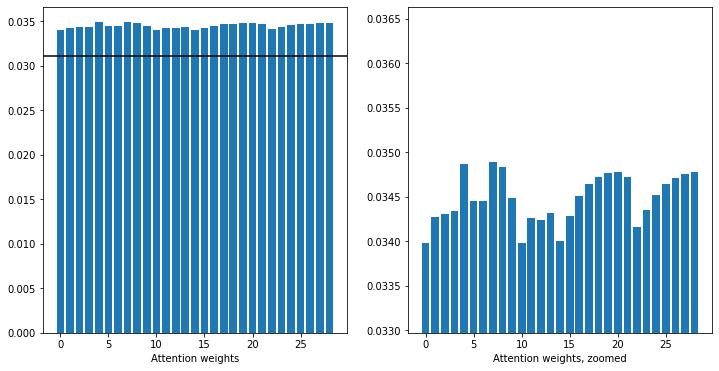

In [46]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

#### **Decoder**
The decoder job is to generate predictions for the next output token. 

This is getting long, so found another tutorial the difference it's in the tensorflow addons section so it manages alot of heavy lifting..

Will continue on this later, but this was a good exercise, learnt alot along the way. 